![](TikTok.jpg)
# TikTok Video Classification Project: Redevelop Models with Tokenized Text Column
*Purpose*\
TikTok is a platform for producing and viewing short-term mobile videos. Users of the platform can report videos and comments that contain claims versus opinions. With the high number of submissions and interactions on TikTok each day, it is challenging for human moderators to review efficiently each video, comment, and claim concerning content. TikTok wants to reduce the backlog of user reports and prioritize `claim` reports. **The goal of this project is to mitigate misinformation in videos on the TikTok platform by building a reliable machine learning model which will help reduce report backlog**.

* An *opinion* is a personal or group belief or thought concerning any information, action, thought, person, or group, place, or thing
* A *claim* is unqualified information concerning any information, action, thought, person, or group, place, or thing

As presented by TikTok: “any answers, responses, comments, opinions, analysis or recommendations that you are not properly licensed or otherwise qualified to provide (https://www.tiktok.com/legal/page/us/terms-of-service/en ).” \
TikTok safety: https://newsroom.tiktok.com/en-us/safety

*Deliverables*  
>**Appendix 2: Tokenize text column**\
In this section, the Random Forest and XGBoost machine learning models are redeveloped, leveraging the tokenization feature `video_transcription_text`. Tokenization involves breaking down text into smaller components, or tokens, such as words, phrases, or symbols. This process not only facilitates sentiment analysis but also improves the preparation of data for machine learning models, ultimately enhancing the ability to derive actionable insights from video content.

*Data*\
The data set used here comes from the Google Advanced Data Analytics Professional Certificate course on the Coursera platform: https://www.coursera.org/google-certificates/advanced-data-analytics-certificate

*Code and Reports*\
All code and reports for this project are located at: https://github.com/izsolnay/TikTok_Python

# Appendix 2: Redevelop Random forest and XGBoost model, leveraging the tokenization feature `video_transcription_text`

In [2]:
# Import standard operational packages
import numpy as np
import pandas as pd

# Import preprocessing, modeling, and evaluation packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Import from xgboost
from xgboost import XGBClassifier, plot_importance

# Import visualization package
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Save models once fitted
import pickle

# Set Jupyter to display all of the columns (no redaction)
pd.set_option('display.max_columns', None)

In [3]:
# Import data; create df
df0 = pd.read_csv('TikTok_for_NLP.csv')
df0.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,1,7017666017,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97,0,0,1
1,2,1,4014381136,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107,0,0,0
2,3,1,9859838091,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137,0,0,0
3,4,1,1866847991,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131,0,0,0
4,5,1,7105231098,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128,0,0,0


In [4]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19084 entries, 0 to 19083
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   #                               19084 non-null  int64  
 1   claim_status                    19084 non-null  int64  
 2   video_id                        19084 non-null  int64  
 3   video_duration_sec              19084 non-null  int64  
 4   video_transcription_text        19084 non-null  object 
 5   video_view_count                19084 non-null  float64
 6   video_like_count                19084 non-null  float64
 7   video_share_count               19084 non-null  float64
 8   video_download_count            19084 non-null  float64
 9   video_comment_count             19084 non-null  float64
 10  likes_per_view                  19084 non-null  float64
 11  comments_per_view               19084 non-null  float64
 12  shares_per_view                 

In [5]:
# Drop unnecessary columns
df = df0.drop(columns=['#', 'video_id'])

### Prepare data for modelling
* choose evaluation metric: recall, because the goal is to identify Claims videos
* no need to check for multicollinearity - DTs can handle them
* no need to encode. Encoding has already happened.

> 0 (FALSE) or 1 (TRUE)\
claim_status > 1 claim & 0 opinion\
author_ban_status > 1/0 author_ban_status_banned; 0/1 author_ban_status_under review; 0/0 active\
verified_status_verified > 1 verified & 0 not verified

Split the data into:

* features and target variable
* training data(80%) and test data(20%)
* split separate validation data
  * Set 75/25 into a training set and a validation set to get 75% of 80%
* set a random seed so work can be reproduced (0)
* tokenize text column

In [6]:
# Check class balance for target variable claim_status
print(df['claim_status'].value_counts())
print(df['claim_status'].value_counts(normalize=True))

claim_status
1    9608
0    9476
Name: count, dtype: int64
claim_status
1    0.503458
0    0.496542
Name: proportion, dtype: float64


In [7]:
# Subset data into dependent y(target) and independent X variables
y = df['claim_status']
X = df.drop(columns=['claim_status'])

In [8]:
# Verify number of samples in the partitioned data
print('X')
print(X.info())
print('y')
print(y.info())

X
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19084 entries, 0 to 19083
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   video_duration_sec              19084 non-null  int64  
 1   video_transcription_text        19084 non-null  object 
 2   video_view_count                19084 non-null  float64
 3   video_like_count                19084 non-null  float64
 4   video_share_count               19084 non-null  float64
 5   video_download_count            19084 non-null  float64
 6   video_comment_count             19084 non-null  float64
 7   likes_per_view                  19084 non-null  float64
 8   comments_per_view               19084 non-null  float64
 9   shares_per_view                 19084 non-null  float64
 10  text_length                     19084 non-null  int64  
 11  verified_status_verified        19084 non-null  int64  
 12  author_ban_status_banned      

In [9]:
# Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [10]:
# Get balances of each training, validation, and testing sets
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 14), (3817, 14), (3817, 14), (11450,), (3817,), (3817,))

### Tokenize text column

In [11]:
# Set up `CountVectorizer` object to convert a collection of text into a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),   # breaks each video's transcription text into both 2-grams and 3-gram
                            max_features=15,      # takes the 15 most frequently occurring tokens from the entire dataset 
                            stop_words='english') # set words to English
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [12]:
# Fit the vectorizer to X_train (generate the n-grams) 
# Extract numerical features from `video_transcription_text` in X_train
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
# Place the numerical representation of `video_transcription_text` from X_train into a df
# Use get_feature_names_out() to get sets
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# Concatenate X_train and count_df > df `X_train_final`
# Drop `video_transcription_text`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,0.124648,0.000000,0.008042,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,0.029896,0.000245,0.003156,97,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,0.017799,0.000085,0.002162,76,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,0.180638,0.000433,0.047593,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,0.174097,0.000264,0.016618,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# Extract numerical features from `video_transcription_text` in X_val
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
# Place the numerical representation of `video_transcription_text` from X_val into a df
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [17]:
# Concatenate `X_val` and `validation_count_df` > df `X_val_final`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,0.655730,0.000076,0.025241,72,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,0.273221,0.000160,0.049720,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,0.608530,0.003051,0.063932,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,0.063862,0.000609,0.003023,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,0.142063,0.000995,0.026034,104,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [18]:
# Extract numerical features from `video_transcription_text` in X_test
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` into df 
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` > df X_test_final
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,0.196444,0.000451,0.023973,107,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,0.359799,0.000194,0.006971,69,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,0.429157,0.003669,0.071835,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,0.359932,0.000778,0.131747,76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,0.192276,0.000164,0.027615,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# Get balances of each training, validation, & testing sets
X_train_final.shape, X_val_final.shape, X_test_final.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 28), (3817, 28), (3817, 28), (11450,), (3817,), (3817,))

### Build random forest model
* instantiate RF model
* define and tune hyperparameters
* define scoring criteria: use recall as metric
* construct GridSearch cross-validation
* fit model to training data

In [20]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Determine set of hyperparameters
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
             'max_samples': [0.7],
             'min_samples_leaf': [1, 2],
             'min_samples_split': [2, 3],
             'n_estimators': [75, 100, 200],
             }

# Define scoring criteria
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [21]:
# Instantiate the GridSearchCV object
# refit: use recall as metric
RF_NLP_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [22]:
# Fit model to the training data & call magic function time to time execution
%time
RF_NLP_cv.fit(X_train_final, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [23]:
# Examine best average score across all the validation folds
RF_NLP_cv.best_score_

0.9962036238136325

In [24]:
# Examine best combination of hyperparameters
RF_NLP_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

In [25]:
# Create a metrics results table which returns a df with metrics for model with the best mean 'metric' score across all validation folds (cvs)
# In this case: the best mean recall score

def model_results(model_name:str, model_object, metric:str):  # model_name: name, model_object: a fit GridSearchCV object, metric:str
    
    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }
    
    TT_cv_results = pd.DataFrame(model_object.cv_results_) # Create df for all results
    
    best_estimator_results = TT_cv_results.iloc[TT_cv_results[metric_dict[metric]].idxmax(), :] # idxmax() returns a series with the index of the max value for each col
    
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

# Create table of best estimator row results
    table = pd.DataFrame({'Model': [model_name],
                          'Precision': [precision],
                          'Recall': [recall],
                          'Accuracy': [accuracy],
                          'F1': [f1]
                         },)
    return table

In [26]:
# Pass the GridSearch object to the model_results() function.
RF_NLP_cv_results = model_results('Random Forest cv', RF_NLP_cv, 'recall')
RF_NLP_cv_results

,Model,Precision,Recall,Accuracy,F1
0,Random Forest cv,0.999826,0.996204,0.997991,0.99801


#### Pickle the model(save)

In [27]:
# Pickle the model
with open('RF_NLP_TikTok.pickle', 'wb') as to_write: # wb = write binary
    pickle.dump(RF_NLP_cv, to_write)

### Build an XGBoost model

In [28]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Determine set of hyperparameters
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define scoring criteria
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [29]:
# Instantiate the GridSearchCV object
# refit: use recall as metric
XGB_NLP_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [30]:
# Fit the model to the X_train_final and y_train data 
%time
XGB_NLP_cv.fit(X_train_final, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [31]:
# Examine best score
XGB_NLP_cv.best_score_

0.9913708291794634

In [32]:
# Examine best parameters
XGB_NLP_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 300}

In [33]:
# Pass the GridSearch object to the model_results() function.
XGB_NLP_cv_results = model_results('XGB_NLP_cv', XGB_NLP_cv, 'recall')
XGB_NLP_cv_results

,Model,Precision,Recall,Accuracy,F1
0,XGB_NLP_cv,0.999825,0.991371,0.995546,0.995578


In [34]:
# Pickle the model
with open('XGB_NLP_cvTikTok.pickle', 'wb') as to_write:
    pickle.dump(XGB_NLP_cv, to_write)

### Use models with validation set
* Random forest model
* XGBoost model

In [35]:
# Use random forest model to predict on validation data with best tree
RF_NLP_val_preds = RF_NLP_cv.best_estimator_.predict(X_val_final)

In [36]:
# Create get_val_scores funtion to create a table with scores on validation data set
def get_val_scores(model_name:str, preds, y_val_data):   

    accuracy = accuracy_score(y_val_data, preds)
    precision = precision_score(y_val_data, preds)
    recall = recall_score(y_val_data, preds)
    f1 = f1_score(y_val_data, preds)
    
# Create table of best estimator row results
    table = pd.DataFrame({'Model': [model_name],
                          'Precision': [precision],
                          'Recall': [recall],
                          'Accuracy': [accuracy],
                          'F1': [f1]
                          },)

    return table

In [37]:
# Pass the scores get_test_scores function
RF_NLP_val = get_val_scores('Random Forest val', RF_NLP_val_preds, y_val)
RF_NLP_val

,Model,Precision,Recall,Accuracy,F1
0,Random Forest val,1.0,0.997922,0.998952,0.99896


In [38]:
# Use XGBoost model to predict on validation data with best tree
XGB_NLP_val_preds = XGB_NLP_cv.best_estimator_.predict(X_val_final)

In [39]:
# Pass the scores get_test_scores function 
XGB_NLP_val = get_val_scores('XGBoost val', XGB_NLP_val_preds, y_val)
XGB_NLP_val

,Model,Precision,Recall,Accuracy,F1
0,XGBoost val,1.0,0.991688,0.995808,0.995827


## Use best model on test data

In [40]:
# Use XGBoost model to predict on test data with best tree
RF_NLP_test_preds = RF_NLP_cv.best_estimator_.predict(X_test_final)

In [41]:
# Use get_test_scores funtion to create a table with test scores
def get_test_scores(model_name:str, preds, y_test_data):   # model_name: name, preds: predictions, y_test_data: y_test data

    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    
# Create table of best estimator row results
    table = pd.DataFrame({'Model': [model_name],
                          'Precision': [precision],
                          'Recall': [recall],
                          'Accuracy': [accuracy],
                          'F1': [f1]
                          },)

    return table

In [42]:
# Pass the scores get_test_scores function.
RF_NLP_test = get_test_scores('Random Forest TEST', RF_NLP_test_preds, y_test)
RF_NLP_test

,Model,Precision,Recall,Accuracy,F1
0,Random Forest TEST,1.0,0.999471,0.999738,0.999735


#### Create a confusion matrix

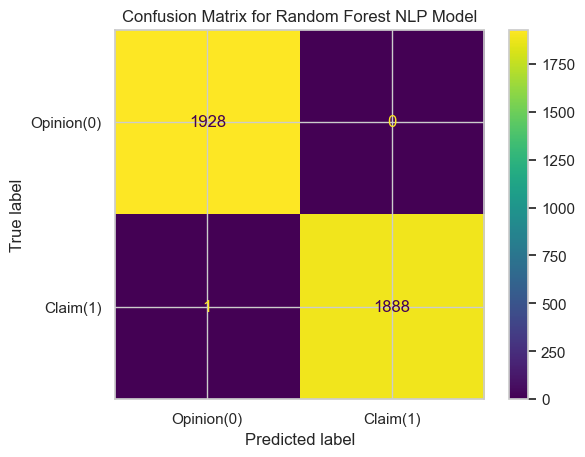

In [43]:
# Create confusion matrix to visualize how accurate classifier is at predicting the labels for a categorical variable
cm = confusion_matrix(y_test, RF_NLP_test_preds, labels=RF_NLP_cv.classes_)

# Visualize confusion matrix
RF_NLP_disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Opinion(0)', 'Claim(1)'])
RF_NLP_disp.plot()
plt.title('Confusion Matrix for Random Forest NLP Model');

### Visualize feature importances

In [44]:
# Calculate feature importance 
importances = RF_NLP_cv.best_estimator_.feature_importances_
feature_importances = pd.Series(importances, index=X_test_final.columns).sort_values(ascending=False)

feature_importances = pd.DataFrame(pd.Series(importances, index=X_test_final.columns).sort_values(ascending=False))
feature_importances

,0
video_view_count,0.536972
video_like_count,0.297398
video_download_count,0.077557
video_share_count,0.033266
video_comment_count,0.030878
likes_per_view,0.009392
media claim,0.002560
discussion board,0.001355
internet forum,0.001223
colleague read,0.001190


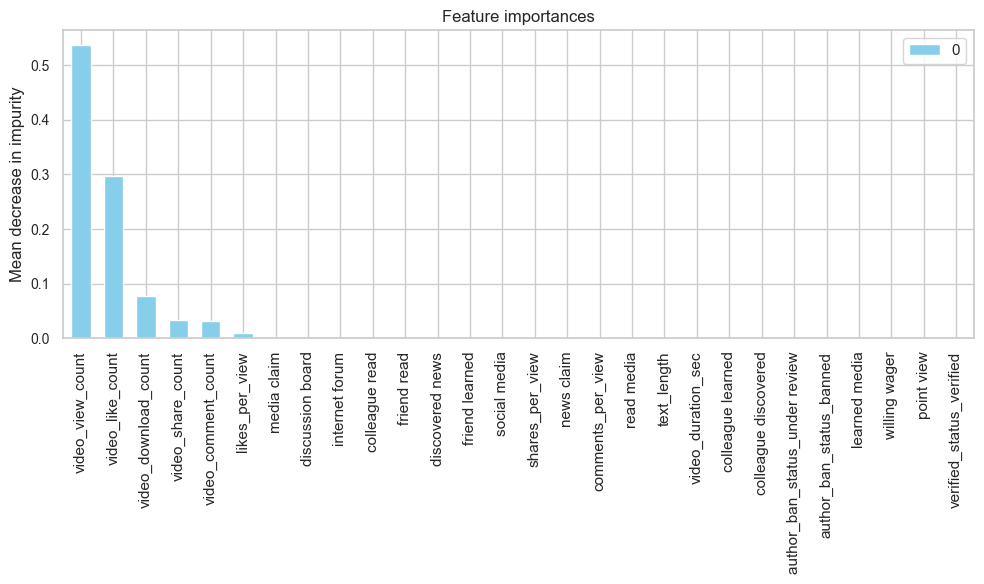

In [45]:
# Plot feature importance 
fig, ax = plt.subplots(figsize=(10, 6))
feature_importances.plot.bar(ax=ax, width=0.6, color='skyblue')  # Adjust bar width and color
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')

ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

## Results
After tokenization, the random forest model scored a near 100% on all metrics, missing only 1 classification out of the 3817 samples in the testing data.\
As with the winning XGBoost model built without tokenization, `video_view_count` was the most powerfully predictive feature for the random forest model. 
However, unlike the XGBoost model, with tokenization, `video_view_count` and `video_like_count` were next most predictive for the random forest model. 
Finally, `video_download_count`, `video_share_count`, and `video_comment_count` were also predictive.

Of the two-word n-grams, the most predictive were `media claim`, `discussion board`, and `internet forum`.\

`verified_status_verified` had no predictive power.